# Vertex AI - UI Based Modelling

## Create Vertex Dataset

1. Create dataset from BigQuery


## Train Vertex Model

1. Dataset -> train new model
2. Step 5: Check columns (22 features)
3. Step 5: Check Goal - Multiclass Only LOG-LOSS

## Analyze Vertex Model

1. Model Registry -> Evaluate

## Deploy Vertex Model

1. Model Registry -> Deploy & Test

## Run Inferences

## Environment

In [3]:
from google.cloud import aiplatform
from google.cloud import storage
from google.cloud import bigquery

import numpy as np
import pandas as pd
import io
import json

In [7]:
ORGANIZATION = 906807308400
PROJECT_ID = '84023181660'
REGION = "us-central1"

In [42]:
aiplatform.init(project=PROJECT_ID, location=REGION)
gcs = storage.Client(project=PROJECT_ID)
bucket = gcs.bucket("insper-pads-cloud")

## Load Data From GCS

In [45]:
blob = bucket.blob("diabetes_dataset.csv")

In [46]:
data = blob.download_as_bytes()
df_data = pd.read_csv(io.BytesIO(data))

In [47]:
df_data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25.0,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28.0,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27.0,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24.0,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45.0,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18.0,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28.0,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23.0,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


In [48]:
# Get prediction rows
# TODO: select only TEST
df_sample = df_data.sample(10)

pred_dicts = df_sample.drop(columns="Diabetes_012").to_dict(orient="records")

df_y = df_sample[['Diabetes_012']]

### Get prediction endpoint

In [49]:
# TODO: review name of endpoint
endpoint = aiplatform.Endpoint.list(filter=f"display_name=diabetes-automl-vertex")[0]
endpoint.display_name

'diabetes-automl-vertex'

### Prepare predictions

In [50]:
def convert_types(k, v):
    if 'BMI' in k:
        return float(v)
    else:
        return str(int(v))
    

pred_dicts = [{k: convert_types(k,v) for k, v in d.items()} for d in pred_dicts]


In [51]:
pred_dicts[0]


{'HighBP': '0',
 'HighChol': '0',
 'CholCheck': '1',
 'BMI': 30.0,
 'Smoker': '0',
 'Stroke': '0',
 'HeartDiseaseorAttack': '0',
 'PhysActivity': '1',
 'Fruits': '1',
 'Veggies': '1',
 'HvyAlcoholConsump': '0',
 'AnyHealthcare': '1',
 'NoDocbcCost': '0',
 'GenHlth': '3',
 'MentHlth': '0',
 'PhysHlth': '0',
 'DiffWalk': '0',
 'Sex': '1',
 'Age': '7',
 'Education': '6',
 'Income': '8'}

### Run predictions

In [52]:
prediction = endpoint.predict(instances=pred_dicts)
prediction

Prediction(predictions=[{'scores': [0.9144476652145386, 0.08555234968662262], 'classes': ['0', '1']}, {'scores': [0.3204842209815979, 0.6795157194137573], 'classes': ['0', '1']}, {'scores': [0.5757936239242554, 0.424206405878067], 'classes': ['0', '1']}, {'scores': [0.9888500571250916, 0.01114985719323158], 'classes': ['0', '1']}, {'scores': [0.9610409140586853, 0.03895894065499306], 'classes': ['0', '1']}, {'scores': [0.9946804642677307, 0.005319452378898859], 'classes': ['0', '1']}, {'scores': [0.9623799920082092, 0.03762000426650047], 'classes': ['0', '1']}, {'scores': [0.9904971718788147, 0.009502776898443699], 'classes': ['0', '1']}, {'scores': [0.7468633055686951, 0.2531366944313049], 'classes': ['0', '1']}, {'scores': [0.5541894435882568, 0.4458105266094208], 'classes': ['0', '1']}], deployed_model_id='4001623091267502080', metadata=None, model_version_id='1', model_resource_name='projects/84023181660/locations/us-central1/models/265333046503276544', explanations=None)

In [53]:
df_y.loc[:, 'y_hat'] = [p["classes"][np.argmax(p["scores"])] for p in prediction.predictions]
df_y.loc[:, 'prob'] = [p["scores"][np.argmax(p["scores"])] for p in prediction.predictions]

/tmp/ipykernel_42224/121715769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.loc[:, 'y_hat'] = [p["classes"][np.argmax(p["scores"])] for p in prediction.predictions]
/tmp/ipykernel_42224/121715769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.loc[:, 'prob'] = [p["scores"][np.argmax(p["scores"])] for p in prediction.predictions]


In [54]:
df_y = df_y.reset_index(drop = True)

In [55]:
df_y

,Diabetes_012,y_hat,prob
0,0,0,0.914448
1,2,1,0.679516
2,0,0,0.575794
3,0,0,0.988850
4,0,0,0.961041
5,0,0,0.994680
6,0,0,0.962380
7,0,0,0.990497
8,2,0,0.746863
9,0,0,0.554189


### Explain predictions

In [56]:
explanation = endpoint.explain(instances=pred_dicts)

In [57]:
PRED_ID = 8

In [58]:
df_y.loc[PRED_ID]

Diabetes_012           2
y_hat                  0
prob            0.746863
Name: 8, dtype: object

In [59]:
explanation.explanations[PRED_ID]

attributions {
  baseline_output_value: 0.977081298828125
  instance_output_value: 0.74686330556869507
  feature_attributions {
    struct_value {
      fields {
        key: "Veggies"
        value {
          number_value: 0
        }
      }
      fields {
        key: "Stroke"
        value {
          number_value: 0
        }
      }
      fields {
        key: "Smoker"
        value {
          number_value: 0
        }
      }
      fields {
        key: "Sex"
        value {
          number_value: -0.04309142231941223
        }
      }
      fields {
        key: "PhysHlth"
        value {
          number_value: 0
        }
      }
      fields {
        key: "PhysActivity"
        value {
          number_value: 0
        }
      }
      fields {
        key: "NoDocbcCost"
        value {
          number_value: 0
        }
      }
      fields {
        key: "MentHlth"
        value {
          number_value: 0
        }
      }
      fields {
        key: "Income"
        

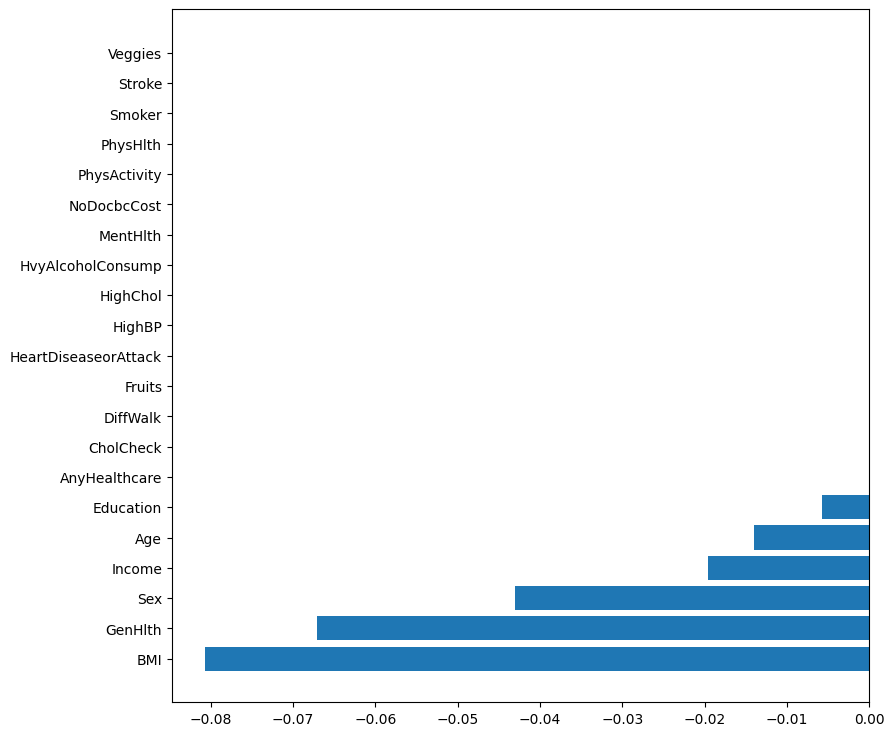

In [60]:
import matplotlib.pyplot as plt

features = []
scores = []
for k in explanation.explanations[PRED_ID].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[PRED_ID].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()